# Оптимизация расходов для металлургического комбината ООО «Так закаляем сталь»

## Задача проекта ##

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**План выполнения работы:**

1.Предобработаем данные
- проверим данные на наличие пропусков и заменим пропуски на нулевое значение либо удалим
- выявим аномалии и удалим их если они сильно выделяются из реальных данных
2.Добавим признаки:
- суммарную мощность
- продолжительность нагрева
3.Объединим данные по столбцу `key` (столбец `key` есть во всех предоставленных данных)

4.Разделим данные на Train:Test - 3:1

5.Обучить несколько моделей

6.Сравнить результаты, выбрать лучшую модель при помощи метрики MAE и проверим ее на тестовой выборке

## Описание этапов обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

**Целевой признак:** последняя измеренная температура

**Метрика:** МАЕ. 

**Качество:** 6.8 и ниже

**RANDOM_STATE** = 50623

# 1. Подготовка и анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

In [3]:
RANDOM_STATE = 50623

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [5]:
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [6]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv')
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

**Данные об электродах:**

In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


В данные `arc` мы можем добавить дополнительно 2 столбца с длительностью нагрева потому как у нас есть информация о начале и конце нагрева дугой, а так же можем расчитать полную мощность по формуле: корень суммы квадратов активной и реактивной мощностей.


$$
S = \sqrt{P^{2} + Q^{2}}
$$

In [8]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В столбце реактивная мощность наблюдаются аномальные значения в виде -715

In [9]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [10]:
data_arc.isnull().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

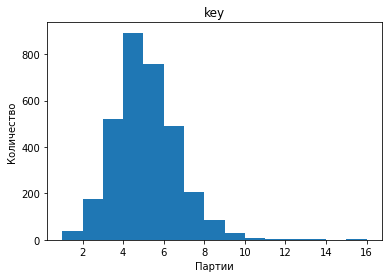

In [11]:
plt.hist((list(data_arc['key'].value_counts())), bins=15)
plt.title('key')
plt.xlabel('Партии')
plt.ylabel('Количество')
plt.show()

Из графика следует, что в данных представлено 16 циклов, а значения в столбце `key` показывает номер партии

**Данные объема подачи сыпучих материалов:**

In [12]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [14]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
data_bulk.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Видим большое количество пропусков. Скорее всего это связано с тех процессом на определенных этапах плавки.

**Данные времени подачи сыпучих материалов:**

In [16]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [17]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [18]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [19]:
data_bulk_time.isnull().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество пропусков идентично данным `bulk`

**Данные продувки сплава газом:**

In [20]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [21]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [22]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [23]:
data_gas.isnull().sum()

key      0
Газ 1    0
dtype: int64

**Данные объема подачи проволочных материалов:**

In [24]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [26]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [27]:
data_wire.isnull().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Аналогичная ситуация как и с сыпучими примесями.

**Данные времени подачи проволочных материалов:**

In [28]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [30]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [31]:
data_wire_time.isnull().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Пропуски идентичны данным `wire`

**Данные температурных режимов:**

In [32]:
data_temp.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [33]:
data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [34]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [35]:
data_temp.isnull().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [36]:
data_temp[data_temp['Температура'].isnull()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


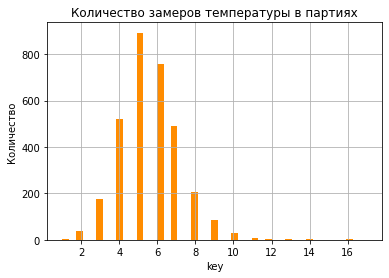

In [37]:
data_temp['key'].value_counts().hist(color="DarkOrange", bins=45)
plt.title('Количество замеров температуры в партиях')
plt.xlabel('key')
plt.ylabel('Количество')
plt.show()

На данном графике видно что есть партии с количеством замеров равным 1

**Итого:**
В проекте представлены данные технологического процесса выплавки металла на металлургическом комбинате ООО «Так закаляем сталь». данные состоят из 7 датасетов:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

После изучения информации в данных были обнаружены аномалии в виде отрицательной температуры и пропуске в данных о количестве легирующих присадках и времени их подачи, а так же в данных о температуре. 

Ниже представлен краткий план предобработки данных которая нам предстоит:

- В данных `bulk`, `bulk_time`, `wire`, `wire_time` пропуски заменим на нулевые значения.
- В данных `arc` удалим аномальные значения с показателем меньше 0.
- В данных `arc` добавим столбец с полной мощностью высчитав ее по формуле.
- В данных `arc` добавим столбец с временем нагрева.
- Объеденим все данные в одну таблицу по столбцу `key`.

# 2. Предобработка данных

**DATA_ARK**

- Удалим аномальные значения.
- Расчитаем полную мощьность и создадим для нее отдельный столбец.
- Переведем время к типу date_time
- Добавим признак длительность нагрева дугой.

In [38]:
#Удалим аномалии
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]

In [39]:
#Расчитаем и добавим полную мощьность
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

In [40]:
#Приведем дату к типу date_time
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

In [41]:
#Добавим столбец время нагрева электродами в секундах
data_arc['Время нагрева (сек)'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) // pd.Timedelta('1s')

In [42]:
#В данных электродов оставим только значение полной мощьности время нагрева в секундах 
data_arc = data_arc[['key', 'Полная мощность', 'Время нагрева (сек)']]
#Сгруппируем партии в одну строку. Одна партия, одна строка.
data_arc = data_arc.groupby(by = 'key', as_index=False).sum()

*Проверим*

In [43]:
data_arc

,key,Полная мощность,Время нагрева (сек)
0,1,3.718736,1098
1,2,2.588349,811
2,3,5.019223,655
3,4,3.400038,741
4,5,2.816980,869
...,...,...,...
3209,3237,3.250657,909
3210,3238,1.723937,546
3211,3239,6.014480,1216
3212,3240,4.082920,839


In [44]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3214 non-null   int64  
 1   Полная мощность      3214 non-null   float64
 2   Время нагрева (сек)  3214 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 100.4 KB


In [45]:
data_arc.describe()

,key,Полная мощность,Время нагрева (сек)
count,3214.000000,3214.000000,3214.000000
mean,1623.061294,3.810779,794.545115
std,934.739859,1.502804,332.491076
min,1.000000,0.331897,57.000000
25%,817.250000,2.775306,571.000000
50%,1623.500000,3.694219,770.000000
75%,2431.750000,4.696915,983.000000
max,3241.000000,15.288271,4189.000000


**В данных bulk, bulk_time, wire, wire_time пропуски заменим на нулевые значения.**

In [46]:
data_bulk = data_bulk.fillna(0)

In [47]:
data_bulk_time = data_bulk_time.fillna(0)

In [48]:
data_wire = data_wire.fillna(0)

In [49]:
data_wire_time = data_wire_time.fillna(0)

**DATA_TEMP**

- переведем дату в формат date_time
- удалим пропуски
- удалим строки где всего 1 замер температуры

In [50]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

In [51]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [52]:
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)

In [53]:
data_temp['Температура'].isnull().sum()

0

In [54]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14665 entries, 0 to 14664
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   Время замера  14665 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 343.8 KB


In [55]:
#Сортируем температуру по времени замера
data_temp = data_temp.sort_values(by=['Время замера'])

In [56]:
#Группируем по столбцу key
temp_count = data_temp.groupby(by = 'key', as_index=False).count()
#Удалим строки где один замер температуры
one_temp_meas = temp_count[temp_count['Время замера']== 1]['key'].tolist()
data_temp = data_temp.query('key not in @one_temp_meas')

In [57]:
#Группируем данные по первому и последнему значению замера температуры
data_temp = data_temp.groupby(by ='key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Время замера 1', 'Время замера 2','Температура 1','Температура 2']
#Оставим только 3 значения: номер партии, первую и последнюю температуры
data_temp = data_temp[['key','Температура 1','Температура 2']]

In [58]:
data_temp

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


In [59]:
full_data = (data_temp.merge(data_arc, how='inner', on = 'key')
                      .merge(data_wire, how='inner', on = 'key')
                      .merge(data_bulk, how='inner', on = 'key')
                      .merge(data_gas, how='inner', on = 'key'))

In [60]:
full_data

,key,Температура 1,Температура 2,Полная мощность,Время нагрева (сек),Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,3.718736,1098,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,2.588349,811,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5.019223,655,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.400038,741,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,2.816980,869,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.868721,723,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,5.070316,940,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,4.360918,569,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,3.909917,750,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


In [61]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2329 non-null   int64  
 1   Температура 1        2329 non-null   float64
 2   Температура 2        2329 non-null   float64
 3   Полная мощность      2329 non-null   float64
 4   Время нагрева (сек)  2329 non-null   int64  
 5   Wire 1               2329 non-null   float64
 6   Wire 2               2329 non-null   float64
 7   Wire 3               2329 non-null   float64
 8   Wire 4               2329 non-null   float64
 9   Wire 5               2329 non-null   float64
 10  Wire 6               2329 non-null   float64
 11  Wire 7               2329 non-null   float64
 12  Wire 8               2329 non-null   float64
 13  Wire 9               2329 non-null   float64
 14  Bulk 1               2329 non-null   float64
 15  Bulk 2               2329 non-null   f

In [62]:
#Изменим названия столбцов для итоготового датасета
full_data.rename(columns={'Температура 1': 'first_temp', 
                          'Температура 2': 'last_temp',
                          'Полная мощность': 'full_power', 
                          'Время нагрева (сек)': 'heat_time(sec)',
                          'Газ 1': 'gas'}, inplace=True)
full_data

,key,first_temp,last_temp,full_power,heat_time(sec),Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas
0,1,1571.0,1613.0,3.718736,1098,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,2.588349,811,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5.019223,655,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.400038,741,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,2.816980,869,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.868721,723,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,5.070316,940,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,4.360918,569,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,3.909917,750,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


In [63]:
#Изменим оставшиеся названия столбцов для итоготового датасета 
full_data.rename(columns={'Wire 1': 'wire_1', 
                          'Wire 2': 'wire_2',
                          'Wire 3': 'wire_3', 
                          'Wire 4': 'wire_4',
                          'Wire 5': 'wire_5',
                          'Wire 6': 'wire_6',
                          'Wire 7': 'wire_7',
                          'Wire 8': 'wire_8',
                          'Wire 9': 'wire_9'}, inplace=True)

In [64]:
full_data.rename(columns={'Bulk 1': 'bulk_1', 
                          'Bulk 2': 'bulk_2',
                          'Bulk 3': 'bulk_3', 
                          'Bulk 4': 'bulk_4',
                          'Bulk 5': 'bulk_5',
                          'Bulk 6': 'bulk_6',
                          'Bulk 7': 'bulk_7',
                          'Bulk 8': 'bulk_8',
                          'Bulk 9': 'bulk_9',
                          'Bulk 10': 'bulk_10',
                          'Bulk 11': 'bulk_11',
                          'Bulk 12': 'bulk_12',
                          'Bulk 13': 'bulk_13',
                          'Bulk 14': 'bulk_14',
                          'Bulk 15': 'bulk_15'}, inplace=True)

In [65]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             2329 non-null   int64  
 1   first_temp      2329 non-null   float64
 2   last_temp       2329 non-null   float64
 3   full_power      2329 non-null   float64
 4   heat_time(sec)  2329 non-null   int64  
 5   wire_1          2329 non-null   float64
 6   wire_2          2329 non-null   float64
 7   wire_3          2329 non-null   float64
 8   wire_4          2329 non-null   float64
 9   wire_5          2329 non-null   float64
 10  wire_6          2329 non-null   float64
 11  wire_7          2329 non-null   float64
 12  wire_8          2329 non-null   float64
 13  wire_9          2329 non-null   float64
 14  bulk_1          2329 non-null   float64
 15  bulk_2          2329 non-null   float64
 16  bulk_3          2329 non-null   float64
 17  bulk_4          2329 non-null   f

Text(0.5, 1.0, 'Heatmap corr')

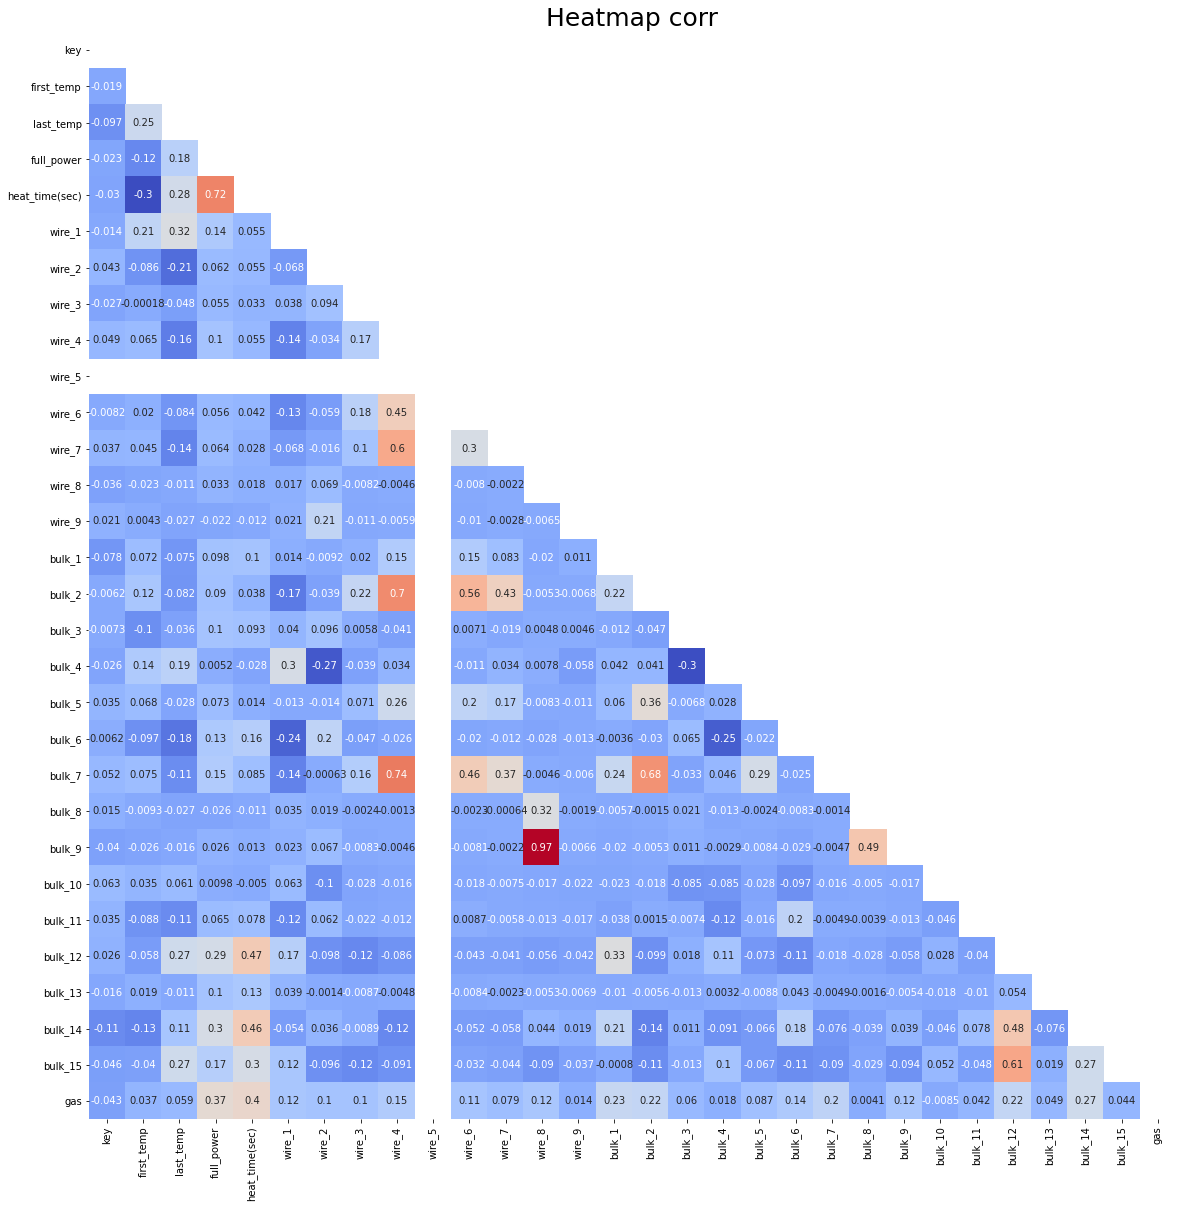

In [66]:
plt.figure(figsize=(20, 20))
matrix = np.triu(full_data.corr())
heatmap = sns.heatmap(full_data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='coolwarm',
                      cbar=False,
                      fmt='.2g')
heatmap.set_title('Heatmap corr', fontsize=25)

In [67]:
full_data.corr()['last_temp'].sort_values(ascending=False)[1:]

wire_1            0.317575
heat_time(sec)    0.278716
bulk_12           0.267424
bulk_15           0.266414
first_temp        0.252443
bulk_4            0.187970
full_power        0.175668
bulk_14           0.114617
bulk_10           0.061350
gas               0.059160
wire_8           -0.010767
bulk_13          -0.010920
bulk_9           -0.016075
bulk_8           -0.026587
wire_9           -0.027488
bulk_5           -0.028355
bulk_3           -0.035977
wire_3           -0.047537
bulk_1           -0.075206
bulk_2           -0.082454
wire_6           -0.084034
key              -0.097242
bulk_7           -0.107275
bulk_11          -0.114753
wire_7           -0.137262
wire_4           -0.159719
bulk_6           -0.181816
wire_2           -0.206672
wire_5                 NaN
Name: last_temp, dtype: float64

Проверим получившиеся признаки на мультиколлениарнось

In [68]:
display(full_data[['first_temp', 'last_temp',
       'heat_time(sec)', 'full_power']].corr())

,first_temp,last_temp,heat_time(sec),full_power
first_temp,1.000000,0.252443,-0.304995,-0.120201
last_temp,0.252443,1.000000,0.278716,0.175668
heat_time(sec),-0.304995,0.278716,1.000000,0.719734
full_power,-0.120201,0.175668,0.719734,1.000000


Наблядается повышенная зависимость у времени нагрева и полной мощности и у wire_8 и wire_4. 

**ВЫВОД**

В ходе проведения предобработки данных было выполнено несколько этапов:

- Удалил пропуски, где нет возможности восстановить данные
- Где было возможно, заполнил пропуски нулевыми значениями
- Добавил признак полную мощьность
- Добавил признак длительности нагрева электродами в секундах
- Сгруппировал данные по партиям
- Объеденил все в один датасет
- Удалил строки где был всего один замер температуры
- Привел названия столбцов к правильному виду


# 3. Обучение модели

*Разделим данные Train:Test - 3:1*

In [69]:
train, test = train_test_split(full_data, test_size=0.25, random_state=RANDOM_STATE)

In [70]:
features_train = train.drop(['last_temp'], axis =1)
target_train = train['last_temp']

features_test = test.drop(['last_temp'], axis =1)
target_test = test['last_temp']

Масштабируем признаки чтобы уменьшить переобучение модели

In [71]:
# разобьем подвыборки для кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=50623)

In [72]:
#Проверим разделение данных
for i in [features_train, features_test]:
    print(i.shape)

(1746, 29)
(583, 29)


**CatBoostRegressor**

In [73]:
%%time
param_GSCV_cat = {'max_depth': np.arange(5, 7),
                  'iterations': np.arange(400, 500, 100),
                  'learning_rate': np.arange(0.02, 0.10, 0.03)
                 }

GSCV_cat = GridSearchCV(CatBoostRegressor(random_state=50623), 
                        param_GSCV_cat,
                        verbose=True,
                        cv=kf,
                        scoring='neg_mean_absolute_error'
                       )

GSCV_cat.fit(features_train, target_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 11.0628260	total: 71.2ms	remaining: 28.4s
1:	learn: 11.0049484	total: 75ms	remaining: 14.9s
2:	learn: 10.9560732	total: 78.4ms	remaining: 10.4s
3:	learn: 10.9093830	total: 81.6ms	remaining: 8.08s
4:	learn: 10.8593707	total: 84.9ms	remaining: 6.7s
5:	learn: 10.8031876	total: 88.2ms	remaining: 5.79s
6:	learn: 10.7503403	total: 91.7ms	remaining: 5.15s
7:	learn: 10.7135808	total: 95ms	remaining: 4.65s
8:	learn: 10.6675084	total: 100ms	remaining: 4.35s
9:	learn: 10.6227230	total: 104ms	remaining: 4.05s
10:	learn: 10.5749285	total: 108ms	remaining: 3.81s
11:	learn: 10.5307192	total: 111ms	remaining: 3.59s
12:	learn: 10.4821766	total: 115ms	remaining: 3.41s
13:	learn: 10.4372332	total: 118ms	remaining: 3.25s
14:	learn: 10.3963824	total: 121ms	remaining: 3.11s
15:	learn: 10.3524397	total: 125ms	remaining: 2.99s
16:	learn: 10.3162755	total: 128ms	remaining: 2.89s
17:	learn: 10.2745578	total: 132ms	remaining: 2.79s
18:	learn: 

GridSearchCV(cv=KFold(n_splits=5, random_state=50623, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f07777613d0>,
             param_grid={'iterations': array([400]),
                         'learning_rate': array([0.02, 0.05, 0.08]),
                         'max_depth': array([5, 6])},
             scoring='neg_mean_absolute_error', verbose=True)

In [74]:
print("best MAE:", GSCV_cat.best_score_)
print("best param:", GSCV_cat.best_params_)

best MAE: -6.0300322177280705
best param: {'iterations': 400, 'learning_rate': 0.05, 'max_depth': 6}


In [75]:
%%time
#Проверим модель на тренировочных данных

modelCatBoost = CatBoostRegressor(loss_function="MAE", 
                                  iterations=400, 
                                  learning_rate = 0.05,
                                  max_depth=6, 
                                  verbose = True
                                 )

modelCatBoost.fit(features_train, target_train)
                
predict_train = modelCatBoost.predict(features_train)
mae_train_cat = mean_absolute_error(target_train, predict_train)

0:	learn: 7.8908352	total: 5.15ms	remaining: 2.06s
1:	learn: 7.7922112	total: 9.17ms	remaining: 1.82s
2:	learn: 7.6928475	total: 19.6ms	remaining: 2.59s
3:	learn: 7.6285442	total: 26.5ms	remaining: 2.62s
4:	learn: 7.5692522	total: 31.4ms	remaining: 2.48s
5:	learn: 7.4878216	total: 36.4ms	remaining: 2.39s
6:	learn: 7.4317085	total: 42.8ms	remaining: 2.4s
7:	learn: 7.3510356	total: 47.6ms	remaining: 2.33s
8:	learn: 7.2718460	total: 52.3ms	remaining: 2.27s
9:	learn: 7.1817998	total: 58.7ms	remaining: 2.29s
10:	learn: 7.1263685	total: 63.3ms	remaining: 2.24s
11:	learn: 7.0775423	total: 67.7ms	remaining: 2.19s
12:	learn: 7.0125272	total: 73.1ms	remaining: 2.18s
13:	learn: 6.9525881	total: 77.6ms	remaining: 2.14s
14:	learn: 6.8889261	total: 81ms	remaining: 2.08s
15:	learn: 6.8406607	total: 86.2ms	remaining: 2.07s
16:	learn: 6.7998410	total: 91.2ms	remaining: 2.06s
17:	learn: 6.7630846	total: 95.8ms	remaining: 2.03s
18:	learn: 6.7128306	total: 102ms	remaining: 2.05s
19:	learn: 6.6669999	total

In [76]:
print("best train MAE:", mae_train_cat)

best train MAE: 3.7354273406357805


**Linear Regression**

In [77]:
%%time

features_train_lr = features_train.drop(['wire_8'], axis=1)

param_GSCV_LR = {'fit_intercept':[True, False], 
                 'normalize':[True, False]}

GSCV_LR = GridSearchCV(LinearRegression(), 
                       param_GSCV_LR, 
                       cv=kf,
                       scoring='neg_mean_absolute_error',
                       verbose=False)

GSCV_LR.fit(features_train_lr, target_train)


CPU times: user 1.8 s, sys: 2.73 s, total: 4.53 s
Wall time: 5.29 s


GridSearchCV(cv=KFold(n_splits=5, random_state=50623, shuffle=True),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [78]:
print("best MAE:", GSCV_LR.best_score_)
print("best param:", GSCV_LR.best_params_)

best MAE: -6.501894599631046
best param: {'fit_intercept': True, 'normalize': False}


In [79]:
param_LR = GSCV_LR.best_params_

In [80]:
%%time
#Проверим на тренировочных данных


modelLinearRegression = LinearRegression(**param_LR)
modelLinearRegression.fit(features_train, target_train)
                
predict_train_lr = modelLinearRegression.predict(features_train)
mae_train_lr = mean_absolute_error(target_train, predict_train_lr)

CPU times: user 44.3 ms, sys: 43.3 ms, total: 87.6 ms
Wall time: 69.9 ms


In [81]:
print(param_LR)
print("best train MAE:", mae_train_lr)

{'fit_intercept': True, 'normalize': False}
best train MAE: 6.268557879891168


**Вывод**

После GridSearchCV показала наилучший результат модель CatBoostRegressor значение МАЕ = 6.0, когда у модели LinearRegression МАЕ = 6.5.

С подобранными гиперпараметрами лучший результат показала модель CatBoostRegressor значение МАЕ = 3.735 на тренировочной выборке, когда у модели LinearRegression МАЕ = 6.268. Проверим лучшую модель на тестовых данных. 

In [82]:
%%time
#Проверим на тестовой выборке

modelCatBoost = CatBoostRegressor(loss_function="MAE", 
                                  iterations=400, 
                                  learning_rate = 0.05,
                                  max_depth=6, 
                                  verbose = True
                                 )

modelCatBoost.fit(features_train, target_train)
                
predict_test = modelCatBoost.predict(features_test)
mae_test_cat = mean_absolute_error(target_test, predict_test)

0:	learn: 7.8908352	total: 5.13ms	remaining: 2.05s
1:	learn: 7.7922112	total: 13.2ms	remaining: 2.62s
2:	learn: 7.6928475	total: 18ms	remaining: 2.38s
3:	learn: 7.6285442	total: 21.8ms	remaining: 2.16s
4:	learn: 7.5692522	total: 25.1ms	remaining: 1.98s
5:	learn: 7.4878216	total: 29.9ms	remaining: 1.97s
6:	learn: 7.4317085	total: 37.9ms	remaining: 2.13s
7:	learn: 7.3510356	total: 42.7ms	remaining: 2.09s
8:	learn: 7.2718460	total: 47.6ms	remaining: 2.07s
9:	learn: 7.1817998	total: 52.4ms	remaining: 2.04s
10:	learn: 7.1263685	total: 57.2ms	remaining: 2.02s
11:	learn: 7.0775423	total: 62ms	remaining: 2s
12:	learn: 7.0125272	total: 66.5ms	remaining: 1.98s
13:	learn: 6.9525881	total: 71ms	remaining: 1.96s
14:	learn: 6.8889261	total: 75.4ms	remaining: 1.94s
15:	learn: 6.8406607	total: 79.9ms	remaining: 1.92s
16:	learn: 6.7998410	total: 83.8ms	remaining: 1.89s
17:	learn: 6.7630846	total: 87.3ms	remaining: 1.85s
18:	learn: 6.7128306	total: 91.7ms	remaining: 1.84s
19:	learn: 6.6669999	total: 101

In [83]:
print("best test MAE:", mae_test_cat)

best test MAE: 6.267897414045581


Проверка модели на адекватность

In [84]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train, target_train)   
    predict = dummy.predict(features_test)   
    MAE_dummy = mean_absolute_error(target_test, predict)   
    print('Для', strategy, 'MAE -', MAE_dummy)

Для mean MAE - 8.262913122668033
Для median MAE - 8.252144082332762


Значения МАЕ на DummyRegressor выше чем у CatBoostRegressor, можно утверждать что модель прошла проверку на адекватность

# 4. Анализ полученных результатов

In [85]:
features_imp = train.drop(['last_temp'], axis=1)
importance_cb = (pd.DataFrame({'feature': features_imp.columns, 'importance': modelCatBoost.feature_importances_})
             .sort_values(by='importance', ascending=False)
            .reset_index()
               )

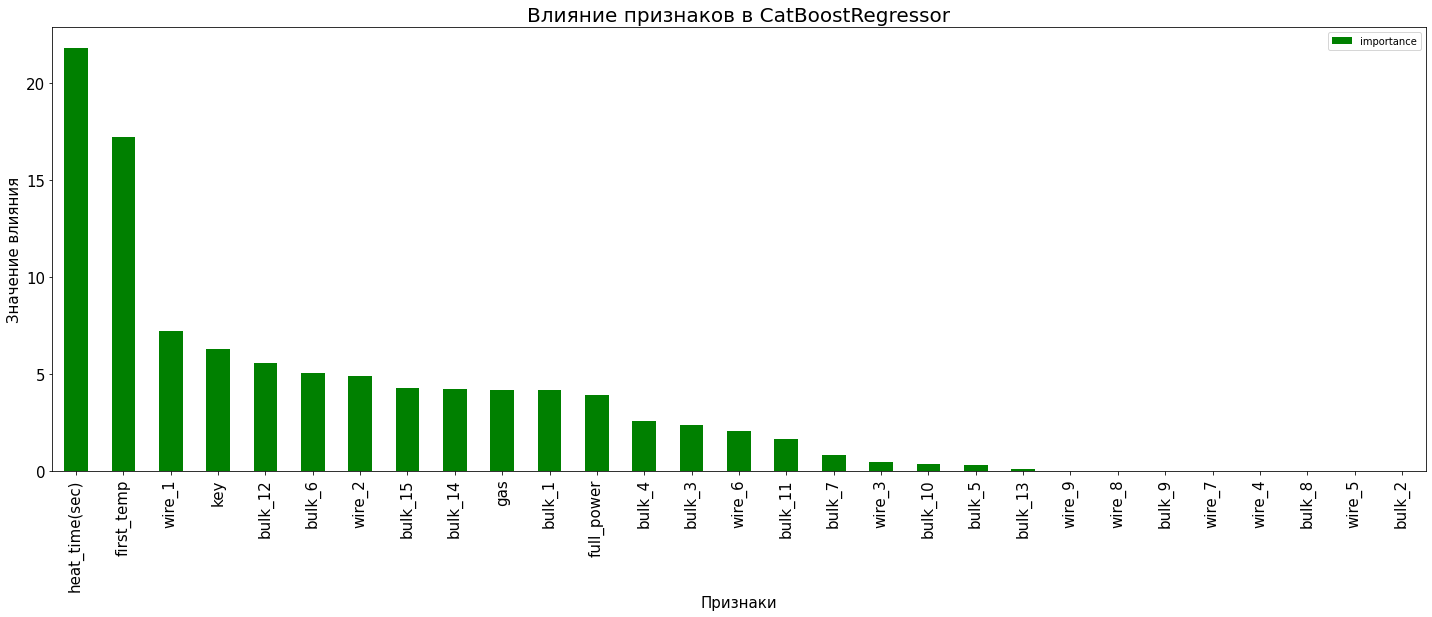

In [86]:
plt.figure(figsize=(20, 15))

plt.subplot(212)    
importance_cb.plot(color='green', kind = 'bar', x='feature', y='importance', fontsize=15, ax=plt.gca(), sharex=False)
plt.xlabel('Признаки', fontsize=15)
plt.ylabel('Значение влияния', fontsize=15)
plt.title('Влияние признаков в CatBoostRegressor', fontsize=20)

plt.tight_layout()

In [87]:
print("best test MAE:", mae_test_cat)

best test MAE: 6.267897414045581


**Вывод**

Исходя из графика можно сказать что самое большое влияние оказывает начальная температура и время нагрева.

Лучшая модель CatBoostRegressor показала test MAE: 6.267

# 5. Итоговый вывод

1. Мною были изучены данные о процессе производства сталей:
    
    - Данные состоят из 7 датасетов:
        - `data_arc_new.csv` — данные об электродах;
        - `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
        - `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
        - `data_gas_new.csv` — данные о продувке сплава газом;
        - `data_temp_new.csv` — результаты измерения температуры;
        - `data_wire_new.csv` — данные о проволочных материалах (объём);
        - `data_wire_time_new.csv` — данные о проволочных материалах (время).


2. Была проведена предобработка данных:

   - В ходе проведения предобработки данных было выполнено несколько этапов:


        - Удалил пропуски, где нет возможности восстановить данные
        - Где было возможно, заполнил пропуски нулевыми значениями
        - Добавил признак полную мощьность
        - Добавил признак длительности нагрева электродами в секундах
        - Сгруппировал данные по партиям
        - Объеденил все в один датасет
        - Удалил строки где был всего один замер температуры
        - Привел названия столбцов к правильному виду


3. На этапе обучения моделей было выполнено несколько действий:

    - Объединил данные по столбцу key (столбец key есть во всех предоставленных данных)
    - После всех манипуляций с данными в финальном датасете осталось 2329 строк и 29 столбцов:
        - `key`
        - `first_temp`
        - `last_temp`
        - `full_power`
        - `heat_time(sec)`
        - `wire_1 - wire_9`
        - `bulk_1 - bulk_15`
        - `gas`           
    - Разделил данные на Train:Test - 3:1 = (1746, 583)
    - Обучил две модели
        - CatBoostRegressor показала train MAE: 3.735 (test MAE: 6.267)
        - LinearRegression показала train MAE: 6.268
    - Сравнил результаты и выбрал лучшую модель CatBoostRegressor при помощи метрики MAE и проверил ее на тестовой выборке
        - CatBoostRegressor показала test MAE: 6.267

# 6. Отчет

1. Какие пункты плана были выполнены, а какие — нет. Почему?
    
    **План выполнения работы:**

        1. Предобработаем данные
    
        2. Добавим признаки
    
        3. Объединим данные по столбцу `key` (столбец `key` есть во всех предоставленных данных)
    
        4. Разделим данные на Train:Test - 3:1
    
        5. Обучить несколько моделей
    
        6. Сравнить результаты, выбрать лучшую модель при помощи метрики MAE и проверим ее на тестовой выборке

    Были выполнены все пункты плана, только добавилось еще пару новых пунктов:
     
        Анализ полученных результатов
     
        Проверка модели на адекватность
     
        Влияние признаков

2. Какие трудности возникли и как вы их преодолели?
    
    - Основная трудность была с обучением моделей, изначально хотел добавить еще LGBMRegressor, но он почему-то не хотел у меня обучаться. Я его оставлял на ночь утром вставал и ничего не менялось. Менял код, Гиперпараметры. в итоге было принято решение оставить 2 модели.
   
    - Было небольшое непонимание что делать с данными в сете с температурой, но тимлид подсказал как быть(было недопонимание небольшое после вебинара)
    
    - Так же возникла трудность с оценкой адекватности модели, но тут помог гугл
    
    В остальном все было приемлимо.
    
3. Какие ключевые шаги в решении задачи вы выделили?
   
   Самые главные шаги были EDA и предобработка данных, именно они по моему мнению обеспечили наиболее качественный анализ и лучшую работу выбранных мной моделей.
   
   После были выбраны модели для обучиния и среди них определена лучшая и она была проверена на тестовой выборке, а так же на адекватность.(Выбор был по параметру МАЕ(Mean absolute error)).
   
4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена? 

    - После всех манипуляций с данными в финальном датасете осталось 2329 строк и 29 столбцов:
        - `key`
        - `first_temp`
        - `last_temp`
        - `full_power`
        - `heat_time(sec)`
        - `wire_1 - wire_9`
        - `bulk_1 - bulk_15`
        - `gas`
    
    - В ходе проведения предобработки данных было выполнено несколько этапов:

        - Удалил пропуски, где нет возможности восстановить данные
        - Где было возможно, заполнил пропуски нулевыми значениями
        - Добавил признак полную мощьность
        - Добавил признак длительности нагрева электродами в секундах
        - Сгруппировал данные по партиям
        - Объеденил все в один датасет
        - Удалил строки где был всего один замер температуры
        - Привел названия столбцов к правильному виду
    
    - Для модели LinearRegression было решено удалить признак `wire_9` потому как у него была выявлена высокая коррелляция.

5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?  
    
    - Обучил две модели
        - CatBoostRegressor показала train MAE: 3.735 (test MAE: 6.267)
        - LinearRegression показала train MAE: 6.268
    - Сравнил результаты и выбрал лучшую модель CatBoostRegressor при помощи метрики MAE и проверил ее на тестовой выборке
        - CatBoostRegressor показала test MAE: 6.267
    - Гиперпараметры
        - 'iterations': 400, 'learning_rate': 0.05, 'max_depth': 6, cv=KFold(n_splits=5, random_state=50623, shuffle=True) 